# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: **label skew**. While **feature skew** is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [1]:
import os
import torch
import pickle
import copy
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.16MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class_counts = Counter(train_labels)
total_train = 0
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} images")
    total_train += count

print(f"----------------Total Train: {total_train} images")


class_counts = Counter(test_labels)
total_test=0
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} images")
    total_test += count

print(f"------------------Total Test: {total_test} images")

Class 0: 4729 images
Class 1: 5470 images
Class 2: 4762 images
Class 3: 4889 images
Class 4: 4655 images
Class 5: 4324 images
Class 6: 4748 images
Class 7: 4968 images
Class 8: 4653 images
Class 9: 4802 images
----------------Total Train: 48000 images
Class 0: 1194 images
Class 1: 1272 images
Class 2: 1196 images
Class 3: 1242 images
Class 4: 1187 images
Class 5: 1097 images
Class 6: 1170 images
Class 7: 1297 images
Class 8: 1198 images
Class 9: 1147 images
------------------Total Test: 12000 images


In [3]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 1: Centralized Vs Federated Scenario

In this task, you will analyze the theoretical equivalence between FedSGD and a centralized training scenario. The code for both implementations has been provided. To minimize differences caused by floating-point precision, a batch size of 1 is used, along with full-batch gradient descent. You may change the device to cpu if you wish, as gpu will not be utilized for batch size of 1.

Since we are working with batch size 1 and full-batch gradient descent, accuracy is not the focus here. Instead, you will monitor gradient divergence by tracking the sum or magnitude of the gradients at each round and observe how they evolve in both settings.

Theoretically, FedSGD and centralized training should yield equivalent results. However, in this task, you may observe discrepancies. Your objective is to understand the code and identify the error that causes this divergence. You may want to review why FedSGD and full-batch centralized gradient descent are theoretically equivalent by revisiting the gradient descent steps on the global objective, as covered in class. Finally, assess whether the code aligns with these theoretical steps. If you believe they should not be equivalent, provide a reasoned justification.

In [ ]:
num_clients = 5
dirichlet_alpha = 0.8
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)

In [ ]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = 0
    for count in client_data_counts:
        total_data_count += count

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = 0
            for update in client_update_device.values():
                client_update_sum += update.abs().sum().item()
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = 0
        for update in avg_update.values():
            avg_update_sum += update.abs().sum().item()
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates



def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1} for local client")
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        # Loop over batches
        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = local_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}

    return overall_update


In [ ]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = centralized_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name]  for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = 0
        for update in epoch_update.values():
            epoch_update_sum += update.abs().sum().item()

        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates


In [ ]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [ ]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

In [ ]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

In [ ]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

# Task 2: FedAvg

Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [5]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [6]:
def fedavg_training(global_model, train_loaders, num_clients, alpha, rounds, epochs, lr, test_loaders, extreme=False):
    round_avg_updates = []
    round_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model = global_model.to(device)

    zero_model, one_model = None, None

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    client_ratios = [round(count / sum(client_data_counts),3) for count in client_data_counts]
    print(f"Alpha: {alpha} Client Data Counts: {client_data_counts} Client Ratios: {client_ratios} sums up to approx {sum(client_ratios)}")

    # Begin FedAvg process for specified rounds
    for round_num in range(rounds):
        client_updates = []

        # Each client trains on local data and provides an update
        for client_idx in range(num_clients):
            print(f"Training Client {client_idx+1} Round {round_num+1} Dirichlet Alpha={alpha}")
            if extreme:
                client_update, m = local_train_fedavg(global_model, train_loaders[client_idx], epochs, lr,device, extreme)
                if client_idx == 0:
                  zero_model = m
                if client_idx == 1:
                  one_model = m
            else:
              client_update = local_train_fedavg(global_model, train_loaders[client_idx], epochs, lr,device, extreme)
            client_updates.append(client_update)

        # Average the updates from all clients
        # avg_update = {name: torch.mean(torch.stack([client_updates[i][name] for i in range(num_clients)]), dim=0)
        #               for name in client_updates[0].keys()}

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_ratios[client_id] * client_updates[client_id][name]      #weighted averaging
            avg_update[name] = grad_sum

        # Apply the average update to the global model
        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

        # Record metrics for this round
        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)
        round_avg_updates.append(avg_update)
        round_accuracies.append(total_accuracy)

    if extreme:
        return zero_model, one_model, round_accuracies
    return round_avg_updates, round_accuracies



def local_train_fedavg(global_model, train_loader, epochs, lr,device, extreme):

    model = SimpleCNN()
    model.load_state_dict(global_model.state_dict())
    model = model.to(device)

    # Optimizer setup for local model training
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Track parameter updates to return
    initial_params = {name: param.clone() for name, param in model.state_dict().items()}

    # Training loop for the client model
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if epoch==epochs-1 or epoch==0:
          print(f"Client Training - Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Calculate the update (difference) from initial parameters
    overall_update = {name:  initial_params[name] - model.state_dict()[name] for name in initial_params.keys()}

    if extreme:
        return overall_update, model

    return overall_update


## Normal FedAvg

In [ ]:
# for alpha in [5,2,0.1]:
#     train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, 5, alpha, 128)
#     client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
#     client_ratios = [round(count / sum(client_data_counts),3) for count in client_data_counts]
#     print(f"Alpha: {alpha} Client Data Counts: {client_data_counts} Client Ratios: {client_ratios} sums up to approx {sum(client_ratios)}")

Alpha: 2 Client Data Counts: [8391, 11133, 8617, 11391, 8468] Client Ratios: [0.175, 0.232, 0.18, 0.237, 0.176] sums up to 1.0
Alpha: 0.5 Client Data Counts: [8338, 13807, 7305, 12085, 6465] Client Ratios: [0.174, 0.288, 0.152, 0.252, 0.135] sums up to 1.001
Alpha: 0.1 Client Data Counts: [4858, 13934, 6773, 13442, 8993] Client Ratios: [0.101, 0.29, 0.141, 0.28, 0.187] sums up to 0.9990000000000001


In the following code you may change the learning rate or the batch size

In [ ]:
# Hyperparameters
batch_size = 128
lr = 0.001
# Fixed params
num_clients = 5
rounds = 3
epochs = 20
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders, _ , _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, alpha, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    print("-----------------------------------------------------------------------------------------")
    accuracies_per_alpha.append(round_accuracies)

#25 seconds for 1 round with 5 clients for 20 epochs per client (3.5 minutes for 3 rounds, 3 alphas)

Alpha: 2 Client Data Counts: [10892, 9989, 7297, 10272, 9550] Client Ratios: [0.227, 0.208, 0.152, 0.214, 0.199] sums up to approx 1.0
Training Client 1 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2824
Client Training - Epoch [20/20], Loss: 1.7705
Training Client 2 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.3111
Client Training - Epoch [20/20], Loss: 1.8178
Training Client 3 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2977
Client Training - Epoch [20/20], Loss: 2.0650
Training Client 4 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.3063
Client Training - Epoch [20/20], Loss: 1.9203
Training Client 5 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2684
Client Training - Epoch [20/20], Loss: 1.6585

Evaluating Client 0
Client 0 Accuracy: 15.19%

Evaluating Client 1
Client 1 Accuracy: 22.20%

Evaluating Client 2
Client 2 Accuracy: 16.63%

Evaluating Client 3
Client 3 Accuracy: 28.27%

E

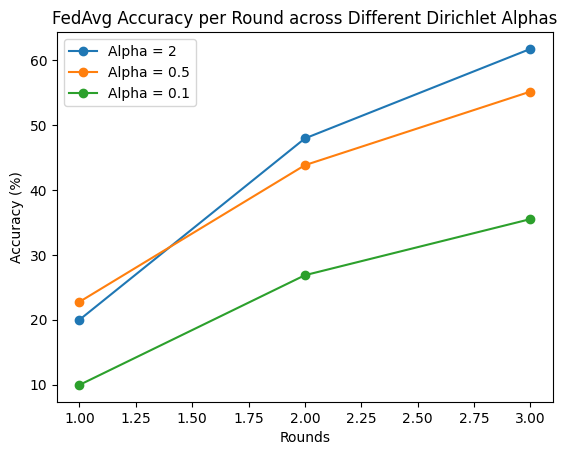

In [ ]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

# try3(latestCODE)

## Extreme FedAvg

In [ ]:
def partition_data_extreme(train_data, train_targets, test_data, test_targets, num_clients=10, batch_size=32):
    """
    Partitions data into 10 clients, each having data from a single class.
    Federated train loaders will contain only one class per client,
    while federated test loaders will have normal class distributions.
    """
    num_classes = len(np.unique(train_targets))
    assert num_clients == num_classes, "Number of clients must equal the number of classes in the dataset."

    # Create federated train data with one class per client
    client_data_indices = {i: [] for i in range(num_clients)}
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        client_data_indices[c].extend(class_indices)
        print(f"Class {c}: {len(class_indices)} images in training data.")

    # Partition test data normally (all classes distributed)
    client_test_indices = defaultdict(list)
    for c in range(num_classes):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = len(class_indices) // num_clients
        for i in range(num_clients):
            client_test_indices[i].extend(class_indices[i * split_sizes: (i + 1) * split_sizes])

    # Create Federated Loaders for Train (1 class per client)
    federated_train_loaders = []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=True, drop_last=False)
        federated_train_loaders.append(train_loader)

    # Create Federated Loaders for Test (distributed across clients)
    federated_test_loaders = []
    for i in range(num_clients):
        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loaders for Training and Testing
    centralized_train_data = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
    centralized_train_targets = torch.tensor(train_targets, dtype=torch.long)
    train_centralized_loader = DataLoader(TensorDataset(centralized_train_data, centralized_train_targets), batch_size=batch_size, shuffle=True, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader

In [ ]:
# Hyperparameters
batch_size = 128
lr = 0.001
# Fixed params
num_clients = 10
rounds = 3
epochs = 20

def run_fedavg_extreme(alpha):
    train_loaders, test_loaders, _ , _ = partition_data_extreme(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, batch_size)
    global_model_fedavg = SimpleCNN()
    zero_model, one_model, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, alpha, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders, extreme=True)
    return round_accuracies, zero_model, one_model

accuracies_per_alpha = []
round_accuracies ,zero_model, one_model  = run_fedavg_extreme("doesn't matter")
accuracies_per_alpha.append(round_accuracies)

Exception ignored in: <function BaseCAM.__del__ at 0x7cba4a4493f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 189, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'
Exception ignored in: <function BaseCAM.__del__ at 0x7cba4a4493f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 189, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'
Exception ignored in: <function BaseCAM.__del__ at 0x7cba4a4493f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 189, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Class 0: 4729 images in training data.
Class 1: 5470 images in training data.
Class 2: 4762 images in training data.
Class 3: 4889 images in training data.
Class 4: 4655 images in training data.
Class 5: 4324 images in training data.
Class 6: 4748 images in training data.
Class 7: 4968 images in training data.
Class 8: 4653 images in training data.
Class 9: 4802 images in training data.
Alpha: doesn't matter Client Data Counts: [4729, 5470, 4762, 4889, 4655, 4324, 4748, 4968, 4653, 4802] Client Ratios: [0.099, 0.114, 0.099, 0.102, 0.097, 0.09, 0.099, 0.103, 0.097, 0.1] sums up to approx 0.9999999999999999
Training Client 1 Round 1 Dirichlet Alpha=doesn't matter
Client Training - Epoch [1/20], Loss: 2.1625
Client Training - Epoch [20/20], Loss: 0.0067
Training Client 2 Round 1 Dirichlet Alpha=doesn't matter
Client Training - Epoch [1/20], Loss: 2.2604
Client Training - Epoch [20/20], Loss: 0.0072
Training Client 3 Round 1 Dirichlet Alpha=doesn't matter
Client Training - Epoch [1/20], Lo

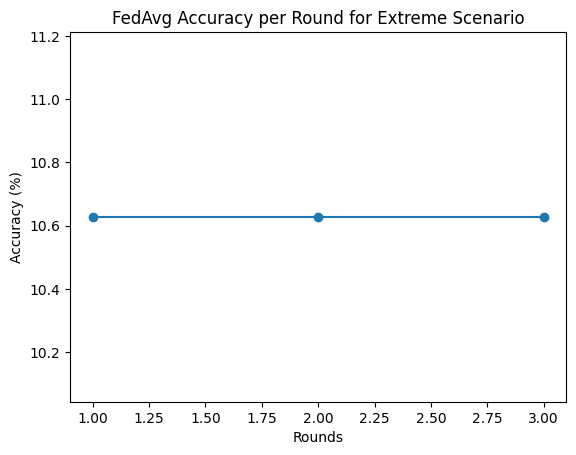

In [ ]:
plt.figure()
plt.plot(range(1, rounds + 1), accuracies_per_alpha[0], marker='o')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedAvg Accuracy per Round for Extreme Scenario')
plt.show()

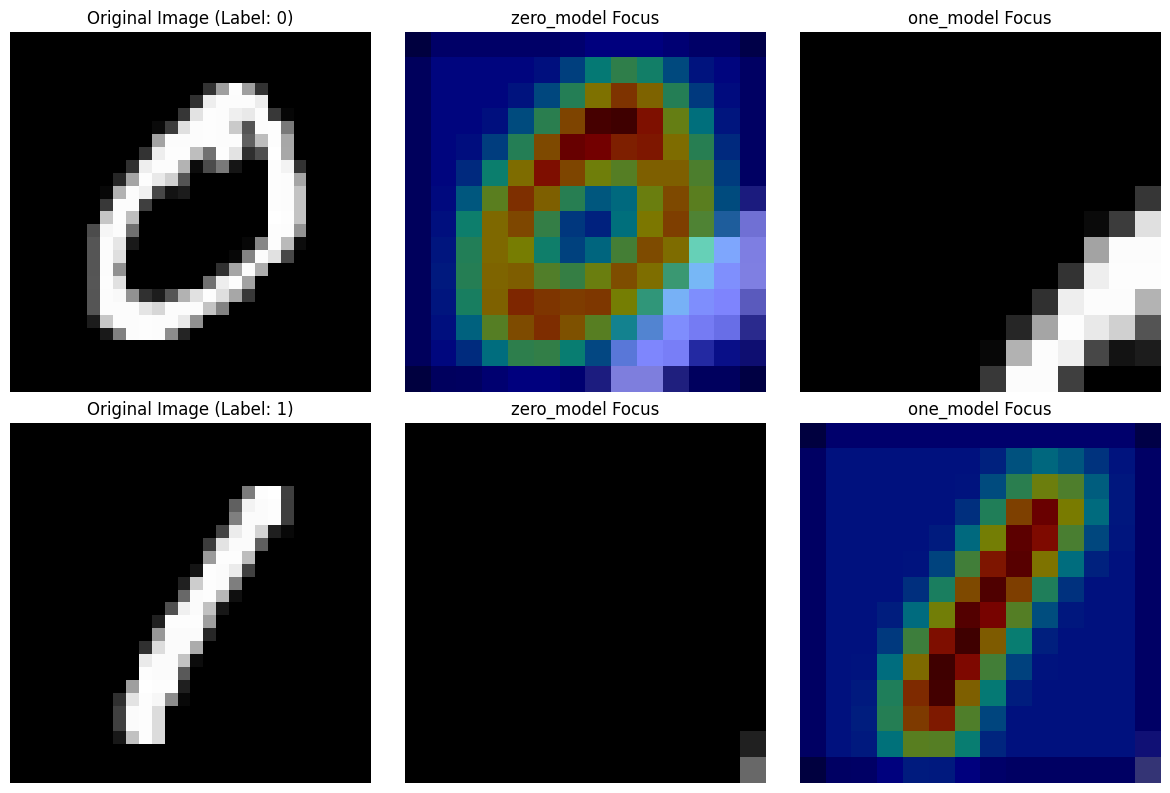

In [ ]:
digit_0_image = None
digit_1_image = None

# Loop through the dataset to find an image of digit 0 and 1
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    if label == 0 and digit_0_image is None:
        digit_0_image = image
    if label == 1 and digit_1_image is None:
        digit_1_image = image
    if digit_0_image is not None and digit_1_image is not None:
        break


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to capture gradients and activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_tensor)
        target = output[:, target_class]

        # Backward pass
        target.backward()

        # Calculate weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = F.relu(cam)

        # Normalize CAM
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam

# Grad-CAM Instances
grad_cam_0 = GradCAM(zero_model, target_layer=zero_model.conv2)  # Target the last convolutional layer
grad_cam_1 = GradCAM(one_model, target_layer=one_model.conv2)

# Visualize Grad-CAM for the selected images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (image, label) in enumerate(zip([digit_0_image, digit_1_image], [0, 1])):
    input_tensor = image.to(torch.float32).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(next(zero_model.parameters()).device)  # Move to the same device as the model
    cam_0 = grad_cam_0.generate_cam(input_tensor, label)
    cam_1 = grad_cam_1.generate_cam(input_tensor, label)

    # Plot original image
    axes[i, 0].imshow(image.squeeze().numpy(), cmap="gray")
    axes[i, 0].set_title(f"Original Image (Label: {label})")
    axes[i, 0].axis("off")

    # Plot Grad-CAM for zero_model
    axes[i, 1].imshow(image.squeeze().numpy(), cmap="gray")
    axes[i, 1].imshow(cam_0.cpu().numpy(), cmap="jet", alpha=0.5)
    axes[i, 1].set_title("zero_model Focus")
    axes[i, 1].axis("off")

    # Plot Grad-CAM for one_model
    axes[i, 2].imshow(image.squeeze().numpy(), cmap="gray")
    axes[i, 2].imshow(cam_1.cpu().numpy(), cmap="jet", alpha=0.5)
    axes[i, 2].set_title("one_model Focus")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Task 3: Scaffold

In this task, you will implement the SCAFFOLD algorithm, which addresses client heterogeneity through variance reduction. We will evaluate the implementation in a 0.1 Dirichlet heterogeneous setting, and accuracy plotting code is provided.

The implementation of SCAFFOLD is similar to FedAvg, with only a few additional steps at both the server and client side. For reference, you may consult the SCAFFOLD paper to understand these adjustments in detail.

In [12]:
def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr, device):

    # Store initial global weights
    init_server_weights = { name: param.clone().to(device) for name, param in model.state_dict().items() }

    # Initialize the local update
    overall_update = { name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}
    new_c_local = { name: tensor.clone() for name, tensor in c_local.items()}

    # Set up optimizer and device
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    model = model.to(device)
    model.train()

    # Training loop
    localsteps = 0
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            localsteps+=1
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
            loss.backward()

            # Update with control variates according to SCAFFOLD formula
            # with torch.no_grad():
            for name, param in model.named_parameters():
                    control_update = c_global[name] - c_local[name]
                    param.grad.data += control_update

            optimizer.step()

        if epoch == epochs - 1 or epoch == 0:
          print(f"Client Training - Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Calculate overall model update
    with torch.no_grad():
        for name, param in model.state_dict().items():
            overall_update[name] =  param -  init_server_weights[name]

        # Update local control variate
        # beta = 1.0 / (epochs * len(train_loader) *10 )  # Control variate learning rate
        beta = 1.0 / (localsteps * lr)
        for name in new_c_local.keys():
            new_c_local[name] = (c_local[name] - c_global[name]) + beta * overall_update[name]

    return overall_update, new_c_local

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, alpha, local_lr):

    round_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize global control variate and per-client local control variates
    c_global = {name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items() }
    c_locals = [{ name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items() } for _ in range(num_clients)]


    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    client_ratios = [count / sum(client_data_counts) for count in client_data_counts]
    print(f"Alpha: {alpha} Client Data Counts: {client_data_counts} Client Ratios: {client_ratios} sums up to approx {sum(client_ratios)}")

    global_model = global_model.to(device)

    for round in range(rounds):
        participating_clients = range(num_clients)
        local_updates, control_updates = [], []

        # Client update loop
        for client_idx in participating_clients:
            print(f"***********************************************Training Client {client_idx+1} Round {round+1} Dirichlet Alpha {alpha}")
            local_model = copy.deepcopy(global_model)
            model_update, new_c_local = local_train_scaffold(local_model,train_loaders[client_idx],c_global,c_locals[client_idx],epochs,local_lr,device)

            # Store updates
            local_updates.append(model_update)
            control_updates.append({name: new_c_local[name] - c_locals[client_idx][name] for name in new_c_local.keys()})

            # Update client's control variate
            c_locals[client_idx] = new_c_local

        # Server update
        with torch.no_grad():
            #try weighted averaging
            # avg_update = {
            #     name: sum(ratio * local_updates[i][name] for i,ratio in enumerate(client_ratios)) for name in global_model.state_dict().keys()
            # }

            # avg_control_update = {
            #     name: sum(ratio * control_updates[i][name] for i,ratio in enumerate(client_ratios))  for name in c_global.keys()
            # }

            # Average model updates and average control variate updates
            avg_update = {name: torch.stack([update[name] for update in local_updates]).mean(0) for name in global_model.state_dict().keys() }
            avg_control_update = {name: torch.stack([update[name] for update in control_updates]).mean(0) for name in c_global.keys() }

            # Update global model
            for name, param in global_model.state_dict().items():
                param.data +=  avg_update[name]

            # Update global control variate
            for name in c_global.keys():
                c_global[name] += avg_control_update[name]

        # Evaluate global model on test data
        _, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)

        print(f"Round {round + 1}/{rounds}, Accuracy: {accuracy:.4f}")

    return round_accuracies

In [13]:
#Hyperparameters
batch_size = 128
lr = 0.001
# Fixed params
num_clients = 5
epochs = 20
rounds = 3
dirichlet_alphas = [2, 0.5, 0.1]

# Run federated SCAFFOLD with 0.1 Dirichlet and plot accuracy per round
def run_scaffold(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs,alpha, local_lr=lr)
    return round_accuracies

# Run SCAFFOLD and get accuracy per round
scaffold_accuracies = []
for alpha in dirichlet_alphas:
    print("-----------------------------------------------------------------------------------------")
    round_accuracies = run_scaffold(alpha)
    scaffold_accuracies.append(round_accuracies)

-----------------------------------------------------------------------------------------
Alpha: 2 Client Data Counts: [11660, 8502, 6106, 10237, 11495] Client Ratios: [0.24291666666666667, 0.177125, 0.12720833333333334, 0.21327083333333333, 0.23947916666666666] sums up to approx 1.0
***********************************************Training Client 1 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.2825
Client Training - Epoch [20/20], Loss: 1.6061
***********************************************Training Client 2 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.2885
Client Training - Epoch [20/20], Loss: 1.9985
***********************************************Training Client 3 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.3135
Client Training - Epoch [20/20], Loss: 2.1564
***********************************************Training Client 4 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.3018
Client Training - Epoch [20/20], 

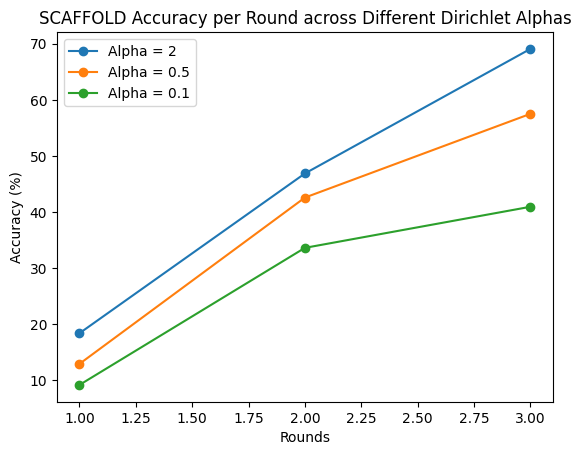

In [14]:
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), scaffold_accuracies[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('SCAFFOLD Accuracy per Round across Different Dirichlet Alphas')
plt.show()

In [25]:
def modified_federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, alpha, local_lr):

    round_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize global control variate and per-client local control variates
    c_global = {name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items() }
    c_locals = [{ name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items() } for _ in range(num_clients)]


    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    client_ratios = [count / sum(client_data_counts) for count in client_data_counts]
    print(f"Alpha: {alpha} Client Data Counts: {client_data_counts} Client Ratios: {client_ratios} sums up to approx {sum(client_ratios)}")

    global_model = global_model.to(device)

    for round in range(rounds):
        participating_clients = range(num_clients)
        local_updates, control_updates = [], []
        c_locals = [c_global for _ in range(num_clients)] ######################### MODIFICATION ############################

        # Client update loop
        for client_idx in participating_clients:
            print(f"***********************************************Training Client {client_idx+1} Round {round+1} Dirichlet Alpha {alpha}")
            local_model = copy.deepcopy(global_model)
            model_update, new_c_local = local_train_scaffold(local_model,train_loaders[client_idx],c_global,c_locals[client_idx],epochs,local_lr,device)

            # Store updates
            local_updates.append(model_update)
            control_updates.append({name: new_c_local[name] - c_locals[client_idx][name] for name in new_c_local.keys()})

            # Update client's control variate
            c_locals[client_idx] = new_c_local

        # Server update
        with torch.no_grad():
            #try weighted averaging
            # avg_update = {
            #     name: sum(ratio * local_updates[i][name] for i,ratio in enumerate(client_ratios)) for name in global_model.state_dict().keys()
            # }

            # avg_control_update = {
            #     name: sum(ratio * control_updates[i][name] for i,ratio in enumerate(client_ratios))  for name in c_global.keys()
            # }

            # Average model updates and average control variate updates
            avg_update = {name: torch.stack([update[name] for update in local_updates]).mean(0) for name in global_model.state_dict().keys() }
            avg_control_update = {name: torch.stack([update[name] for update in control_updates]).mean(0) for name in c_global.keys() }

            # Update global model
            for name, param in global_model.state_dict().items():
                param.data +=  avg_update[name]

            # Update global control variate
            for name in c_global.keys():
                c_global[name] += avg_control_update[name]

        # Evaluate global model on test data
        _, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)

        print(f"Round {round + 1}/{rounds}, Accuracy: {accuracy:.4f}")

    return round_accuracies


def run_modified_scaffold(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_scaffold = SimpleCNN()
    round_accuracies = modified_federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs,alpha, local_lr=lr)
    return round_accuracies

modified_scaffold_accuracies = []
for alpha in dirichlet_alphas:
    print("-----------------------------------------------------------------------------------------")
    round_accuracies = run_modified_scaffold(alpha)
    modified_scaffold_accuracies.append(round_accuracies)

-----------------------------------------------------------------------------------------
Alpha: 2 Client Data Counts: [9954, 9367, 11719, 10213, 6747] Client Ratios: [0.207375, 0.19514583333333332, 0.24414583333333334, 0.21277083333333333, 0.1405625] sums up to approx 1.0
***********************************************Training Client 1 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.2940
Client Training - Epoch [20/20], Loss: 1.9307
***********************************************Training Client 2 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.2904
Client Training - Epoch [20/20], Loss: 1.8832
***********************************************Training Client 3 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.2957
Client Training - Epoch [20/20], Loss: 2.0773
***********************************************Training Client 4 Round 1 Dirichlet Alpha 2
Client Training - Epoch [1/20], Loss: 2.2973
Client Training - Epoch [20/20], Loss: 1.899

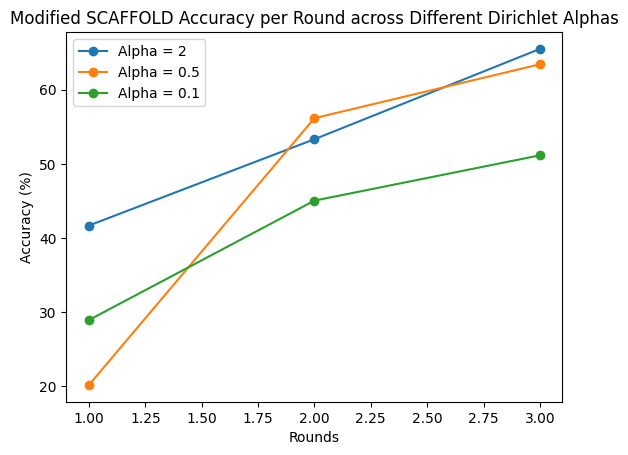

In [24]:
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), modified_scaffold_accuracies[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Modified SCAFFOLD Accuracy per Round across Different Dirichlet Alphas')
plt.show()

# Task 4: Gradient Harmonization

In this task, you will examine how heterogeneity influences the gradient updates sent by each client. Specifically, you will analyze and quantify gradient conflicts at varying levels of heterogeneity.

First, implement the FedAvg code (You can reuse your task 2 implementation) and integrate the provided conflict-counting function at the end of each round to measure the number of conflicts in different heterogeneous settings.

Next, implement the Gradient Harmonization algorithm to harmonize conflicting gradients.

Finally, evaluate the performance of the harmonized gradients under a 0.1 Dirichlet scenario, and compare the number of conflicts before and after harmonization.

In [ ]:
import builtins
sum = builtins.sum

def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

def gradient_conflict_counter(client_updates):
    total_conflicts = 0  # Variable to store the total conflicts across all layers
    num_clients = len(client_updates)

    # Iterate over each layer (key) in the client updates
    for layer_name in client_updates[0].keys():
        # Collect vectors for this layer across all clients
        layer_vectors = [client_update[layer_name].view(-1).cpu() for client_update in client_updates]

        # Check pairwise cosine similarity for this layer and count conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                sim = cosine_similarity(layer_vectors[i], layer_vectors[j])
                if sim < 0:
                    total_conflicts += 1

    print(f"Total gradient conflicts detected: {total_conflicts}")
    return total_conflicts

def Federated_gradient_conflict(global_model, train_loaders, num_clients, alpha, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    conflict_counts = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model = global_model.to(device)

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    client_ratios = [round(count / sum(client_data_counts),3) for count in client_data_counts]
    print(f"Alpha: {alpha} Client Data Counts: {client_data_counts} Client Ratios: {client_ratios} sums up to approx {sum(client_ratios)}")

    # Begin FedAvg process for specified rounds
    for round_num in range(rounds):
        client_updates = []

        # Each client trains on local data and provides an update
        for client_idx in range(num_clients):
            print(f"***********************************************Training Client {client_idx+1} Round {round_num+1} Dirichlet Alpha={alpha}")
            client_update = local_train_fedavg(global_model, train_loaders[client_idx], epochs, lr,device)
            client_updates.append(client_update)

        round_conflicts = gradient_conflict_counter(client_updates)
        conflict_counts.append(round_conflicts)

        # Average the updates from all clients
        # avg_update = {name: torch.mean(torch.stack([client_updates[i][name] for i in range(num_clients)]), dim=0)
        #               for name in client_updates[0].keys()}

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_ratios[client_id] * client_updates[client_id][name]      #weighted averaging
            avg_update[name] = grad_sum

        # Apply the average update to the global model
        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

        # Record metrics for this round
        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)
        round_avg_updates.append(avg_update)
        round_accuracies.append(total_accuracy)

    return round_avg_updates, round_accuracies, conflict_counts

In [ ]:
#Hyperparameters
batch_size = 128
lr = 0.001
# Fixed params
num_clients = 5
rounds = 3
epochs = 20
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies,conflict_counts = Federated_gradient_conflict(global_model_fedavg, train_loaders, num_clients, alpha, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, conflict_counts

accuracies_per_alpha = []
conflicts_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies, conflict_counts = run_fedconflict(alpha)
    accuracies_per_alpha.append(round_accuracies)
    conflicts_per_alpha.append(conflict_counts)


Alpha: 2 Client Data Counts: [11762, 8419, 10442, 8228, 9149] Client Ratios: [0.245, 0.175, 0.218, 0.171, 0.191] sums up to approx 1.0
Training Client 1 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.3045
Client Training - Epoch [20/20], Loss: 1.8133
Training Client 2 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2995
Client Training - Epoch [20/20], Loss: 2.0267
Training Client 3 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2839
Client Training - Epoch [20/20], Loss: 1.8479
Training Client 4 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2932
Client Training - Epoch [20/20], Loss: 1.9880
Training Client 5 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2887
Client Training - Epoch [20/20], Loss: 2.0045
Total gradient conflicts detected: 5

Evaluating Client 0
Client 0 Accuracy: 32.45%

Evaluating Client 1
Client 1 Accuracy: 38.47%

Evaluating Client 2
Client 2 Accuracy: 39.26%

Evaluating 

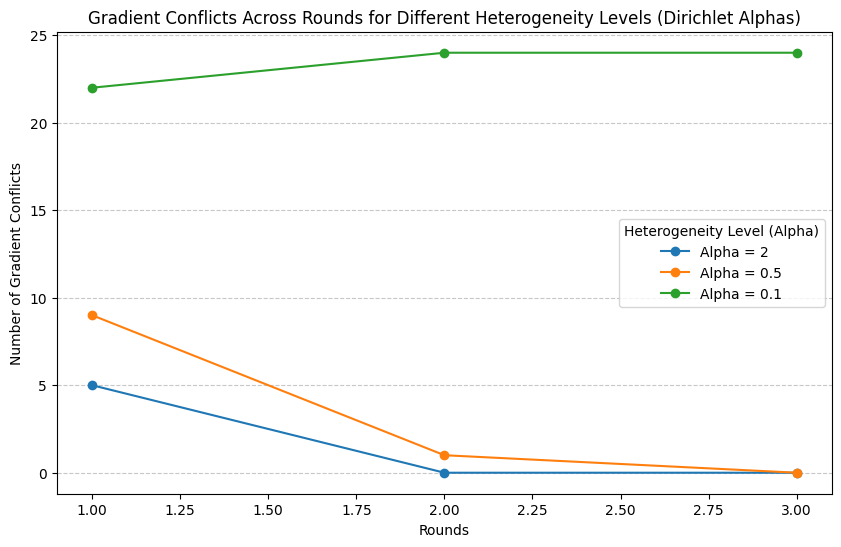

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))

for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), conflicts_per_alpha[i], marker='o', label=f'Alpha = {alpha}')

plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

plt.figure(figsize=(10, 6))

In [ ]:
def gradient_harmonization(client_updates):
    num_clients = len(client_updates)

    # Create a copy of client updates to store harmonized gradients
    harmonized_updates = [{name: tensor.clone() for name, tensor in client_update.items()} for client_update in client_updates]

    for layer_name in client_updates[0].keys():       #FOR ALL LAYERS
        layer_gradients = [client_update[layer_name].view(-1) for client_update in client_updates]   # Collect gradient vectors for this layer across all clients

        for i in range(num_clients):
            for j in range(num_clients):
                if i != j:    # Avoid self-comparison
                    sim = cosine_similarity(layer_gradients[i], harmonized_updates[j][layer_name].view(-1))

                    if sim < 0:  # if negative similarity

                        # Project gi onto the orthogonal plane of gj
                        projection_i = (torch.dot(layer_gradients[i], harmonized_updates[j][layer_name].view(-1)) / harmonized_updates[j][layer_name].view(-1).norm()**2) * harmonized_updates[j][layer_name].view(-1)
                        harmonized_updates[i][layer_name] -= projection_i.view_as(harmonized_updates[i][layer_name])

                        # Project gj onto the orthogonal plane of gi
                        projection_j = (torch.dot(layer_gradients[j], harmonized_updates[i][layer_name].view(-1)) / harmonized_updates[i][layer_name].view(-1).norm()**2) * harmonized_updates[i][layer_name].view(-1)
                        harmonized_updates[j][layer_name] -= projection_j.view_as(harmonized_updates[j][layer_name])

    return harmonized_updates

def Federated_gradient_harmonization(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_accuracies = []  # List to store total accuracy after each round
    pre_harmonization_conflicts = []  # List to store conflicts before harmonization
    post_harmonization_conflicts = []  # List to store conflicts after harmonization

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model = global_model.to(device)

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    client_ratios = [round(count / sum(client_data_counts),3) for count in client_data_counts]
    print(f"Alpha: {alpha} Client Data Counts: {client_data_counts} Client Ratios: {client_ratios} sums up to approx {sum(client_ratios)}")

    # Begin FedAvg process for specified rounds
    for round_num in range(rounds):
        client_updates = []

        # Each client trains on local data and provides an update
        for client_idx in range(num_clients):
            print(f"***********************************************Training Client {client_idx+1} Round {round_num+1} Dirichlet Alpha={alpha}")
            client_update = local_train_fedavg(global_model, train_loaders[client_idx], epochs, lr,device)
            client_updates.append(client_update)

        round_pre_conflicts = gradient_conflict_counter(client_updates)
        pre_harmonization_conflicts.append(round_pre_conflicts)
        client_updates = gradient_harmonization(client_updates)
        round_harmonized_conflicts = gradient_conflict_counter(client_updates)
        post_harmonization_conflicts.append(round_harmonized_conflicts)

        # Average the updates from all clients
        # avg_update = {name: torch.mean(torch.stack([client_updates[i][name] for i in range(num_clients)]), dim=0)
        #               for name in client_updates[0].keys()}

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_ratios[client_id] * client_updates[client_id][name]      #weighted averaging
            avg_update[name] = grad_sum

        # Apply the average update to the global model
        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

        # Record metrics for this round
        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts


In [ ]:
# Hyperparameters
batch_size = 128
lr = 0.001
#Fixed params
num_clients = 5
rounds = 3
epochs = 20
dirichlet_alphas = [2, 0.5, 0.1]

# Run federated gradient harmonization
def run_fedgradharmonized(alpha):
  train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
  global_model_fedavg = SimpleCNN()
  round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = Federated_gradient_harmonization(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
  return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts

accuracies_per_alpha, pre_conflicts, post_conflicts = [], [], []

for alpha in dirichlet_alphas:
    round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts  = run_fedgradharmonized(alpha)
    accuracies_per_alpha.append(round_accuracies)
    pre_conflicts.append(pre_harmonization_conflicts)
    post_conflicts.append(post_harmonization_conflicts)

Alpha: 2 Client Data Counts: [13695, 6576, 11512, 9131, 7086] Client Ratios: [0.285, 0.137, 0.24, 0.19, 0.148] sums up to approx 0.9999999999999999
***********************************************Training Client 1 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2945
Client Training - Epoch [20/20], Loss: 2.0777
***********************************************Training Client 2 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.3036
Client Training - Epoch [20/20], Loss: 2.0481
***********************************************Training Client 3 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2930
Client Training - Epoch [20/20], Loss: 2.0340
***********************************************Training Client 4 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2991
Client Training - Epoch [20/20], Loss: 2.0955
***********************************************Training Client 5 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], L

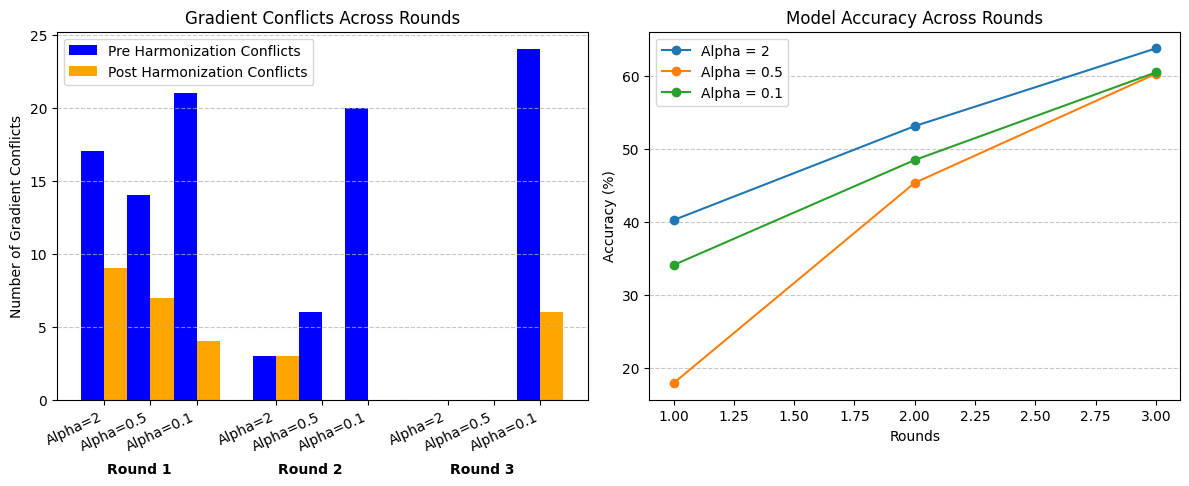

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

# for i, alpha in enumerate(dirichlet_alphas):
#     plt.plot(range(1, rounds + 1), pre_conflicts[i], marker='o', linestyle='-', label=f'Pre Alpha={alpha}')
#     plt.plot(range(1, rounds + 1), post_conflicts[i], marker='x', linestyle='--', label=f'Post Alpha={alpha}')

# Parameters for plotting
width = 0.35  # Width of bars
x = np.arange(rounds)  # x positions for rounds
bar_positions = []

# Calculate bar positions for each alpha in each round
for round_idx in range(rounds):
    round_positions = []
    for alpha_idx, alpha in enumerate(dirichlet_alphas):
        base = round_idx * (len(dirichlet_alphas) * 2 * width + 0.5)  # 0.5 is spacing between rounds
        round_positions.append(base + alpha_idx * 2 * width)  # Group positions
    bar_positions.append(round_positions)

# Flatten bar positions for plotting
bar_positions = np.array(bar_positions).flatten()

# Flatten pre/post conflict data for plotting
flat_pre_conflicts = [pre_conflicts[alpha_idx][round_idx] for round_idx in range(rounds) for alpha_idx in range(len(dirichlet_alphas))]
flat_post_conflicts = [post_conflicts[alpha_idx][round_idx] for round_idx in range(rounds) for alpha_idx in range(len(dirichlet_alphas))]

for i, (pre, post) in enumerate(zip(flat_pre_conflicts, flat_post_conflicts)):
    plt.bar(bar_positions[i], pre, width, label="Pre Harmonization Conflicts" if i == 0 else "", color='blue')
    plt.bar(bar_positions[i] + width, post, width, label="Post Harmonization Conflicts" if i == 0 else "", color='orange')

# Label x-ticks
labels = []
for round_idx in range(rounds):
    for alpha in dirichlet_alphas:
        labels.append(f"Alpha={alpha}")

round_centers = [np.mean(round_positions) for round_positions in bar_positions.reshape(rounds, -1)]
for round_idx, round_center in enumerate(round_centers):
    plt.text(round_center, -5, f"Round {round_idx + 1}", ha='center', fontsize=10, fontweight='bold')

plt.xticks(bar_positions + width / 2, labels, rotation=25, ha="right")

# plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.subplot(1, 2, 2)
for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[i], marker='o', label=f'Alpha = {alpha}')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("FedGH Model Accuracy Across Rounds")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# Task 5: FedSam

In this task, you will explore Sharpness-Aware Minimization (SAM) in a federated learning setting by implementing the FedSAM algorithm. As with previous tasks, evaluate its performance in a 0.1 Dirichlet heterogeneous scenario.

In [26]:
def apply_sam_perturbation(local_model, criterion, x_train, y_train, rho):
    """
    Apply SAM perturbation to compute sharpness-aware updates.

    Args:
        local_model (torch.nn.Module): The model being trained.
        criterion (torch.nn.Module): Loss function.
        x_train (torch.Tensor): Input training data.
        y_train (torch.Tensor): Labels for training data.
        rho (float): SAM perturbation magnitude.

    Returns:
        dict: Perturbed gradients after applying SAM.
    """
    device = next(local_model.parameters()).device
    local_model.train()

    # Forward pass to compute loss
    outputs = local_model(x_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()  # Compute gradients w.r.t. current weights

    # Calculate gradient norm (L2-norm squared)
    grad_norm_squared = 0.0
    for param in local_model.parameters():
        if param.grad is not None:
            grad_norm_squared += (param.grad ** 2).sum()

    # if grad_norm_squared > 100000000000000 :
    #   print("xl")
    # if grad_norm_squared < 1e-15:
    #   print("xs")

    # grad_norm_squared = grad_norm_squared.sqrt()
    grad_norm_squared = (grad_norm_squared + 1e-8).sqrt()

    # Apply SAM perturbation: w˜ = w + (ρ * g / ||g||²)
    with torch.no_grad():
        for param in local_model.parameters():
            if param.grad is not None:
                param += rho * param.grad / grad_norm_squared

    # Compute perturbed gradients
    perturbed_outputs = local_model(x_train.to(device))
    perturbed_loss = criterion(perturbed_outputs, y_train.to(device))
    local_model.zero_grad()
    perturbed_loss.backward()  # Compute gradients w.r.t. perturbed weights

    # Save perturbed gradients
    perturbed_gradients = {name: param.grad.clone() for name, param in local_model.named_parameters()}

    # Revert model to original state
    with torch.no_grad():
        for param in local_model.parameters():
            if param.grad is not None:
                param -= rho * param.grad / grad_norm_squared

    return perturbed_gradients, loss, perturbed_loss

def apply_sagm_perturbation(local_model, criterion, x_train, y_train, rho, alpha):
    """
    Apply SAGM perturbation to compute sharpness-aware gradient matching updates.

    Args:
        local_model (torch.nn.Module): The model being trained.
        criterion (torch.nn.Module): Loss function.
        x_train (torch.Tensor): Input training data.
        y_train (torch.Tensor): Labels for training data.
        p (float): Perturbation radius.
        alpha (float): SAGM hyperparameter.

    Returns:
        dict: Perturbed gradients after applying SAGM.
    """

    device = next(local_model.parameters()).device
    local_model.train()

    # Forward pass to compute loss
    outputs = local_model(x_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()  # Compute gradients w.r.t. current weights

    # Calculate gradient norm (L2-norm squared)
    grad_norm_squared = 0.0
    for param in local_model.parameters():
        if param.grad is not None:
            grad_norm_squared += (param.grad ** 2).sum()

    # if grad_norm_squared > 100000000000000 :
    #   print("xl")
    # if grad_norm_squared < 1e-15:
    #   print("xs")

    # grad_norm_squared = grad_norm_squared.sqrt()
    grad_norm_squared =  (grad_norm_squared + 1e-8).sqrt()

    # Apply the SAGM perturbation: w˜ = w + (ρ/||g||² - α) * g
    with torch.no_grad():
        for param in local_model.parameters():
            if param.grad is not None:
                param += ((rho / grad_norm_squared) - alpha) * param.grad

    # Compute the perturbed loss
    perturbed_outputs = local_model(x_train.to(device))
    perturbed_loss = criterion(perturbed_outputs, y_train.to(device))
    local_model.zero_grad()
    perturbed_loss.backward()  # Compute gradients w.r.t. perturbed weights

    # Save perturbed gradients
    perturbed_gradients = {name: param.grad.clone() for name, param in local_model.named_parameters()}

    # Revert model to original state
    with torch.no_grad():
        for param in local_model.parameters():
            if param.grad is not None:
                param -= (rho / grad_norm_squared - alpha) * param.grad / grad_norm_squared

    return perturbed_gradients, loss, perturbed_loss

In [27]:
def local_train_sam(model, train_loader, epochs, lr, device, sam, rho=0.001, alpha=0.01):  #rho=0.0001, 0.001 , 0.01, 0.1 , alpha in reverse order

    model = model.to(device)
    model.train()

    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    overall_update = {name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_perturbed_loss = 0.0
        for x_train, y_train in train_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)

            if sam:   # Apply SAM perturbation and compute perturbed gradients
              perturbed_gradients, loss, perturbed_loss = apply_sam_perturbation(model, criterion, x_train, y_train, rho)
            else:     # Apply SAGM perturbation and compute perturbed gradients
              perturbed_gradients, loss, perturbed_loss = apply_sagm_perturbation(model, criterion, x_train, y_train, rho, alpha)

            epoch_loss += loss.item()
            epoch_perturbed_loss += perturbed_loss.item()

            # Update weights with perturbed gradients
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        param.grad = perturbed_gradients[name]
                optimizer.step()

            # Accumulate updates
            with torch.no_grad():
                for name, param in model.state_dict().items():
                    overall_update[name] += param - overall_update[name]  # Collect updates

        if epoch==epochs-1 or epoch==0:
              print(f"Client Training - Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Perturbed Loss: {epoch_perturbed_loss / len(train_loader):.4f}, Rho: {rho} SAM:{sam} ")

    return overall_update


def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs,alpha, local_lr,sam=True):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model = global_model.to(device)
    global_model.train()

    round_accuracies = []

    for round_idx in range(rounds):

        client_updates = []
        for client_idx in range(num_clients):
            print(f"***********************************************Training Client {client_idx+1} Round {round_idx+1} Dirichlet Alpha={alpha}")
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())
            client_update = local_train_sam(local_model, train_loaders[client_idx], epochs, local_lr, device,sam)
            client_updates.append(client_update)

        # Aggregate updates
        with torch.no_grad():
            for name, param in global_model.named_parameters():
                update_sum = sum(client_updates[client_idx][name] for client_idx in range(num_clients))
                param += update_sum / num_clients  # Federated averaging

        _, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)

    return round_accuracies

In [31]:
#Hyperparameters
batch_size = 128
lr = 0.001
# Fixed params
num_clients = 5
epochs = 20
rounds = 3
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedsam(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, alpha, local_lr=lr)
    return round_accuracies


# Run FEDSAM and get accuracy per round
sam_accuracies = []
for alpha in dirichlet_alphas:
    print("-----------------------------------------------------------------------------------------")
    round_accuracies = run_fedsam(alpha)
    sam_accuracies.append(round_accuracies)

-----------------------------------------------------------------------------------------
***********************************************Training Client 1 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2903, Perturbed Loss: 2.2921, Rho: 0.001 SAM:True 
Client Training - Epoch [20/20], Loss: 2.0704, Perturbed Loss: 2.0746, Rho: 0.001 SAM:True 
***********************************************Training Client 2 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.3015, Perturbed Loss: 2.3033, Rho: 0.001 SAM:True 
Client Training - Epoch [20/20], Loss: 2.0584, Perturbed Loss: 2.0631, Rho: 0.001 SAM:True 
***********************************************Training Client 3 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 2.2986, Perturbed Loss: 2.3004, Rho: 0.001 SAM:True 
Client Training - Epoch [20/20], Loss: 2.0979, Perturbed Loss: 2.1018, Rho: 0.001 SAM:True 
***********************************************Training Client 4 Round 1 Dirichlet Alpha

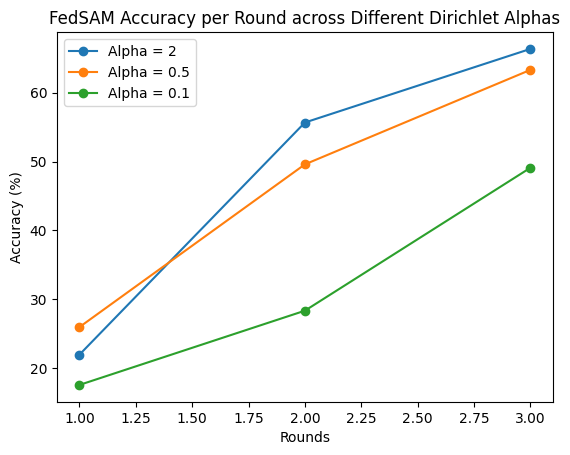

In [32]:
# Plotting accuracy per round for FedSAM with Dirichlet alpha 0.1
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), sam_accuracies[idx], marker='o', label=f'Alpha = {alpha}')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedSAM Accuracy per Round across Different Dirichlet Alphas')
plt.legend()
plt.show()

In [28]:
#Hyperparameters
batch_size = 128
lr = 0.001
# Fixed params
num_clients = 5
epochs = 20
rounds = 3
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedsagm(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_sagm = SimpleCNN()
    round_accuracies = federated_training_sam(global_model_sagm, train_loaders, test_loaders, num_clients, rounds, epochs, alpha, local_lr=lr,sam=False)
    return round_accuracies


# Run FEDSAGM and get accuracy per round
sagm_accuracies = []
for alpha in dirichlet_alphas:
    print("-----------------------------------------------------------------------------------------")
    round_accuracies = run_fedsagm(alpha)
    sagm_accuracies.append(round_accuracies)

-----------------------------------------------------------------------------------------
***********************************************Training Client 1 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 1.6304, Perturbed Loss: 1.2070, Rho: 0.001 SAM:False 
Client Training - Epoch [20/20], Loss: 0.4053, Perturbed Loss: 0.1605, Rho: 0.001 SAM:False 
***********************************************Training Client 2 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 1.6490, Perturbed Loss: 1.2477, Rho: 0.001 SAM:False 
Client Training - Epoch [20/20], Loss: 0.3666, Perturbed Loss: 0.1391, Rho: 0.001 SAM:False 
***********************************************Training Client 3 Round 1 Dirichlet Alpha=2
Client Training - Epoch [1/20], Loss: 1.9324, Perturbed Loss: 1.4754, Rho: 0.001 SAM:False 
Client Training - Epoch [20/20], Loss: 0.4605, Perturbed Loss: 0.1723, Rho: 0.001 SAM:False 
***********************************************Training Client 4 Round 1 Dirichlet

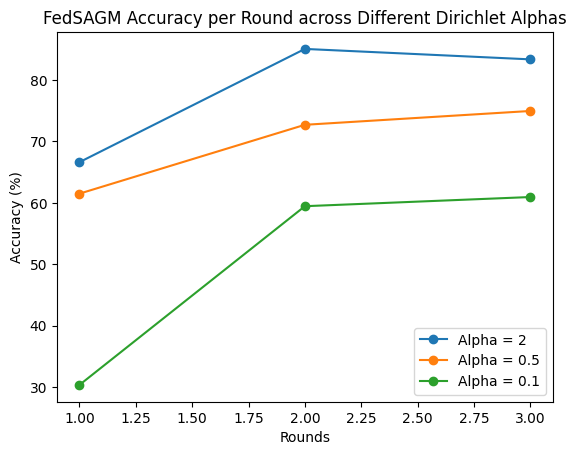

In [29]:
# Plotting accuracy per round for FedSAM with Dirichlet alpha 0.1
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), sagm_accuracies[idx], marker='o', label=f'Alpha = {alpha}')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedSAGM Accuracy per Round across Different Dirichlet Alphas')
plt.legend()
plt.show()

In [ ]:
# https://ar5iv.labs.arxiv.org/html/2303.10353#S3